# Восстановление золота из руды

Необходимо подготовить прототип модели машинного обучения для «Цифры» – компании, которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды по данным о параметрах добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные
2. Провести исследовательский анализ данных
3. Построить и обучить модель

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Открываем-и-изучаем-файлы" data-toc-modified-id="Открываем-и-изучаем-файлы-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Открываем и изучаем файлы</a></span></li><li><span><a href="#Проверяем,-что-эффективность-обогащения-рассчитана-правильно" data-toc-modified-id="Проверяем,-что-эффективность-обогащения-рассчитана-правильно-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Проверяем, что эффективность обогащения рассчитана правильно</a></span></li><li><span><a href="#Анализируем-признаки,-недоступные-в-тестовой-выборке" data-toc-modified-id="Анализируем-признаки,-недоступные-в-тестовой-выборке-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализируем признаки, недоступные в тестовой выборке</a></span></li><li><span><a href="#Проводим-предобработку-данных" data-toc-modified-id="Проводим-предобработку-данных-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Проводим предобработку данных</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Смотрим,-как-меняется-концентрация-металлов-на-различных-этапах-очистки" data-toc-modified-id="Смотрим,-как-меняется-концентрация-металлов-на-различных-этапах-очистки-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Смотрим, как меняется концентрация металлов на различных этапах очистки</a></span></li><li><span><a href="#Сравниваем-распределения-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках" data-toc-modified-id="Сравниваем-распределения-размеров-гранул-сырья-на-обучающей-и-тестовой-выборках-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Сравниваем распределения размеров гранул сырья на обучающей и тестовой выборках</a></span></li><li><span><a href="#Исследуем-суммарную-концентрацию-всех-веществ-на-разных-стадиях" data-toc-modified-id="Исследуем-суммарную-концентрацию-всех-веществ-на-разных-стадиях-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Исследуем суммарную концентрацию всех веществ на разных стадиях</a></span></li></ul></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Напишем-функцию-для-вычисления-итоговой-sMAPE" data-toc-modified-id="Напишем-функцию-для-вычисления-итоговой-sMAPE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Напишем функцию для вычисления итоговой sMAPE</a></span></li><li><span><a href="#Обучим-разные-модели-и-оценим-их-качество-кросс-валидацией" data-toc-modified-id="Обучим-разные-модели-и-оценим-их-качество-кросс-валидацией-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучим разные модели и оценим их качество кросс-валидацией</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Подготовка данных

Подключим необходимые библиотеки и установим полезные умолчания.

In [1]:
!pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import optuna

from urllib.error import HTTPError
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import (LinearRegression, Ridge, SGDRegressor, 
                                  ElasticNet, Lars)
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor

plt.style.use('dark_background');            # Dark theme for plots
plt.rc('grid', color=(.3, .3, .3));          # Pale grid lines
plt.rc('axes', grid=True, axisbelow=True);   # Grid lines behind the plot
pd.set_option('display.max_columns', None);  # Display all dataframe columns
pd.set_option('display.max_rows', 100);      # Display 100 dataframe rows

# Disable warnings
pd.options.mode.chained_assignment = None    
warnings.simplefilter('ignore', pd.errors.PerformanceWarning) 

Определим глобальные константы.

In [3]:
RS = 22221111  # Custom random_state 
CV = 3         # Cross-validation folds

In [4]:
# ---------- PEP 8 recommended maximum line length – 79 characters ----------->

### Открываем и изучаем файлы

Загрузим файлы и взглянем на данные.

In [5]:
for df in ['train', 'test', 'full']:
    path = f'/datasets/gold_recovery_{df}_new.csv'
    if not os.path.exists(path):
        path = 'https://code.s3.yandex.net' + path
    try:
        locals()[df] = pd.read_csv(path)
    except HTTPError as err:
        print(f'{err} {path}')

In [6]:
full

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [7]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [8]:
print(full.shape)
print(train.shape)
print(test.shape)

(19439, 87)
(14149, 87)
(5290, 53)


В датасете `train` то же число столбцов, что и в `full`, а в `test` их гораздо меньше. Соотношение объектов в `train` и `test` примерно 3 к 1.

Проверим датасеты на наличие полных дубликатов.

In [9]:
for df in [full, train, test]:
    print(df.duplicated().sum())

0
0
0


Дублей нет.

### Проверяем, что эффективность обогащения рассчитана правильно

Рассчитаем эффективность обогащения для признака `rougher.output.recovery` на обучающей выборке и сравним с самим признаком.

In [10]:
train['rougher.output.recovery_check'] = (
    100 * train['rougher.output.concentrate_au'] 
    * (train['rougher.input.feed_au'] - train['rougher.output.tail_au'])
    / train['rougher.input.feed_au']
    / (train['rougher.output.concentrate_au'] - train['rougher.output.tail_au'])
)

In [11]:
train[['rougher.output.recovery',
       'rougher.output.recovery_check',
       'rougher.output.concentrate_au', 
       'rougher.input.feed_au', 
       'rougher.output.tail_au',
]]

,rougher.output.recovery,rougher.output.recovery_check,rougher.output.concentrate_au,rougher.input.feed_au,rougher.output.tail_au
0,87.107763,87.107763,19.793808,6.486150,1.170244
1,86.843261,86.843261,20.050975,6.478583,1.184827
2,86.842308,86.842308,19.737170,6.362222,1.162562
3,87.226430,87.226430,19.320810,6.118189,1.079755
4,86.688794,86.688794,19.216101,5.663707,1.012642
...,...,...,...,...,...
14144,89.574376,89.574376,18.603550,5.335862,0.748633
14145,87.724007,87.724007,18.441436,4.838619,0.771582
14146,88.890579,88.890579,15.111231,4.525061,0.685059
14147,89.858126,89.858126,17.834772,4.362781,0.567130


In [12]:
mean_absolute_error(
    train['rougher.output.recovery'],
    train['rougher.output.recovery_check']
)

1.1766465170843896e-14

Среднее абсолютное отклонение расчета от признака фактически равно нулю – признак соответствует названию.

Удалим расчетный столбец за ненадобностью.

In [13]:
train = train.drop(columns=['rougher.output.recovery_check'])

### Анализируем признаки, недоступные в тестовой выборке

Посмотрим, каких столбцов не хватает в `test`.

In [14]:
[col for col in train.columns if col not in test.columns]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Видим выходные параметры каждой стадии, включая два целевых признака, и рассчетные показатели. Вероятная причина исключения этих столбцов из `test` (а значит и из `train` при обучении модели) – предотвращение утечки целевых признаков через тесно связанные с ними параметры.

### Проводим предобработку данных

Приведем столбец `date` к типу `datetime`, сделаем его индексом и упорядочим по возрастанию во всех датасетах.

In [15]:
for df in [full, train, test]:
    df['date'] = df['date'].apply(pd.to_datetime)
    print(df['date'].dtype)
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)

datetime64[ns]
datetime64[ns]
datetime64[ns]


Посмотрим, каким разбиением созданы из `full` датасеты `train` и `test`.

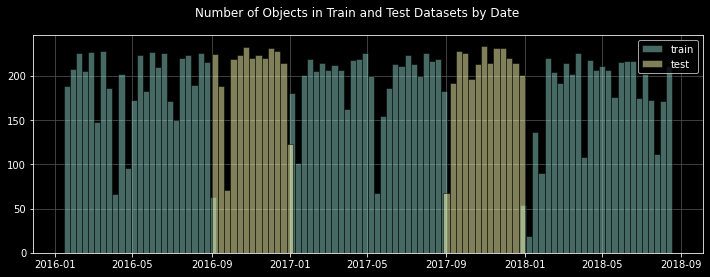

In [16]:
plt.figure(figsize=(12, 4));
plt.suptitle('Number of Objects in Train and Test Datasets by Date');
for i, df in enumerate([train, test]):
    plt.hist(df.index, bins=100//(1+i), alpha=.5, edgecolor='k');
plt.legend(['train', 'test']);

Похоже, что для теста взяли периоды с сентября по декабрь 2016 и 2017 годов, а остальное сделали трейном. 

Посмотрим на число пропусков в столбцах.

In [17]:
full.isna().sum()

final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           24
primary_cleaner.input.depressant                        37
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         104
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 370
primary_cleaner.output.concentrate_au                   

В брифе сказано, что «*cоседние по времени параметры часто похожи*». Пропусков немного, так что заполним их соседними по времени значениями. Так как и в `train`, и в `test` есть разрывы во времени, заполним пропуски в `full`, после чего обновим `train` и `test`.

In [18]:
full = full.fillna(method='ffill')
full.isna().sum().sum()

0

In [19]:
for df in [train, test]:
    df.loc[:, :] = full.loc[df.index, df.columns]
    print(df.shape, df.isna().sum().sum())

(14149, 86) 0
(5290, 52) 0


## Анализ данных

### Смотрим, как меняется концентрация металлов на различных этапах очистки

Для каждого металла построим зависимость его средней по датасету `full` концентрации от стадии.

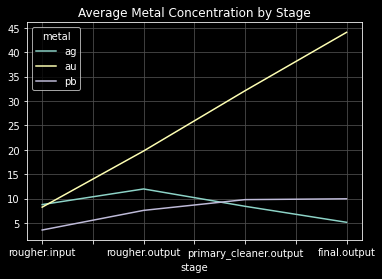

In [20]:
# Calculate mean
avg_conc = pd.DataFrame(
    full[[
        'rougher.input.feed_au',
        'rougher.input.feed_ag',
        'rougher.input.feed_pb',
        'rougher.output.concentrate_au',
        'rougher.output.concentrate_ag',
        'rougher.output.concentrate_pb',
        'primary_cleaner.output.concentrate_au',
        'primary_cleaner.output.concentrate_ag',
        'primary_cleaner.output.concentrate_pb',
        'final.output.concentrate_au',
        'final.output.concentrate_ag',
        'final.output.concentrate_pb',
    ]].mean().T,
    columns=['concentration'],
).reset_index()

# Split feature name to stage and metal
avg_conc['stage'] = (avg_conc['index'].str.slice(stop=-3)
                     .str.replace('(\.[^.]*)$', '', regex=True))
avg_conc['metal'] = avg_conc['index'].str.slice(start=-2)

# Pivot metal to columns and plot result
(
    avg_conc.pivot('stage', 'metal', 'concentration')
    .iloc[[2, 3, 1, 0]]
    .plot(title='Average Metal Concentration by Stage')
);

Концентрация золота стремительно растет с каждой стадией, что ожидаемо. Концентрация сопутствующего серебра растет после флотации, но потом падает при очистке. Концентрация примесного свинца растет с каждой стадией, но гораздо медленнее, чем у золота.

### Сравниваем распределения размеров гранул сырья на обучающей и тестовой выборках

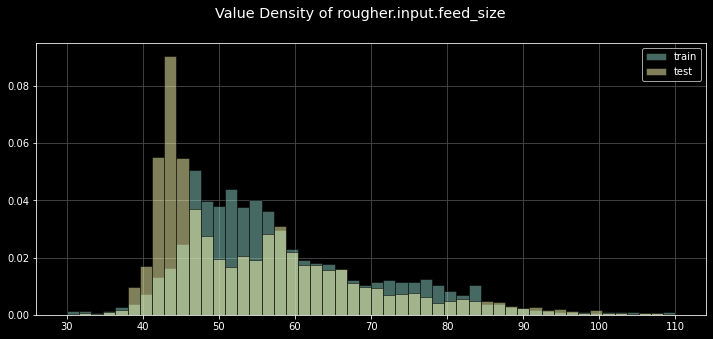

In [21]:
plt.figure(figsize=(12, 5));
for df in [train, test]:
    df['rougher.input.feed_size'].hist(
        bins=50, range=(30, 110), density=True, edgecolor='k', alpha=.5);
plt.legend(['train', 'test']);
plt.suptitle('Value Density of rougher.input.feed_size', fontsize='x-large');

Распределения заметно отличаются в диапазоне 40–55: в обучающей выборке преобладают объекты со значением 45–55, а в тестовой – со значением 40–45. Несмотря на заметное отличие распределений, будем надеяться, что в обучающей выборке все же достаточно объектов с размером гранул сырья 40–45, чтобы обученная модель могла хорошо предсказывать для них таргеты.

### Исследуем суммарную концентрацию всех веществ на разных стадиях

Рассчитаем суммарную концентрацию твердых веществ на каждой стадии и посмотрим, как ее среднее по датасету `full` меняется от стадии к стадии.

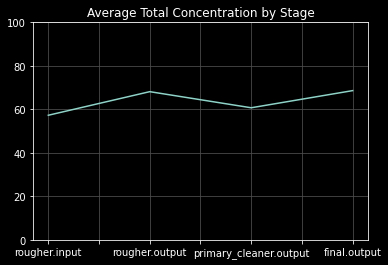

In [22]:
# Calculate total concentration
full['rougher.input.feed_total'] = (
      full['rougher.input.feed_au']
    + full['rougher.input.feed_ag']
    + full['rougher.input.feed_pb']
    + full['rougher.input.feed_sol']
)
full['rougher.output.concentrate_total'] = (
      full['rougher.output.concentrate_au']
    + full['rougher.output.concentrate_ag']
    + full['rougher.output.concentrate_pb']
    + full['rougher.output.concentrate_sol']
)
full['primary_cleaner.output.concentrate_total'] = (
      full['primary_cleaner.output.concentrate_au']
    + full['primary_cleaner.output.concentrate_ag']
    + full['primary_cleaner.output.concentrate_pb']
    + full['primary_cleaner.output.concentrate_sol']
)
full['final.output.concentrate_total'] = (
      full['final.output.concentrate_au']
    + full['final.output.concentrate_ag']
    + full['final.output.concentrate_pb']
    + full['final.output.concentrate_sol']
)
total_conc_columns = [
    'rougher.input.feed_total',
    'rougher.output.concentrate_total',
    'primary_cleaner.output.concentrate_total',
    'final.output.concentrate_total',
]

# Calculate mean
avg_conc_total = full[total_conc_columns].mean().T

# Leave only the stage in index and plot result
avg_conc_total.index = avg_conc_total.index.str.replace('(\.[^.]*)$', '', 
                                                        regex=True)
avg_conc_total.plot(title='Average Total Concentration by Stage', 
                    ylim=(0, 100));

Средняя суммарная концентрация колеблется в диапазоне 60–70 в зависимости от стадии процесса.

Посмотрим на распределение значений суммарной концентрации на разных стадиях.

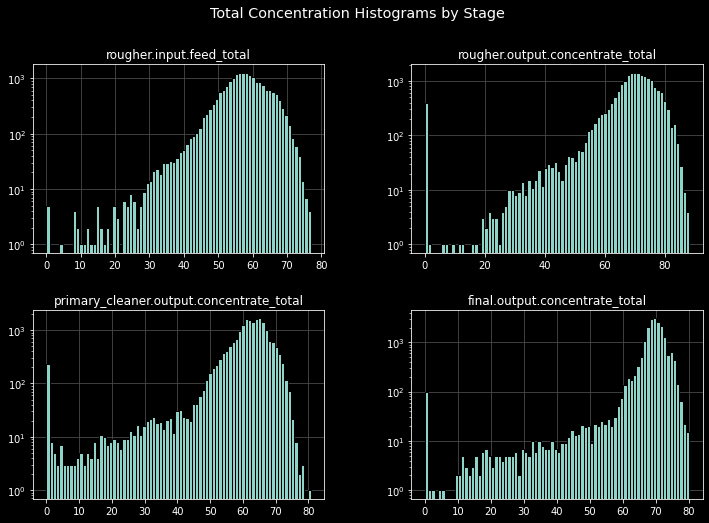

In [23]:
full[total_conc_columns].hist(
    bins=80, edgecolor='k', figsize=(12, 8), log=True);
plt.suptitle('Total Concentration Histograms by Stage', fontsize='x-large');

На всех стадиях наблюдаются аномальные выбросы близкие или равные нулю. Возможно, это сбои/особенности измерительной аппаратуры. Удалим аномалии из всех датасетов.

In [24]:
total_conc_outliers = full[
      (full[total_conc_columns[0]] < 1)
    | (full[total_conc_columns[1]] < 1)
    | (full[total_conc_columns[2]] < 1)
    | (full[total_conc_columns[3]] < 1)
].index

In [25]:
for df in [full, train, test]:
    df.drop(index=total_conc_outliers, errors='ignore', inplace=True)
    print(df.shape)

(18722, 90)
(13599, 86)
(5123, 52)


## Модель

### Напишем функцию для вычисления итоговой sMAPE

In [26]:
def smape(y_true, y_pred):
    '''Calculates total sMAPE for double-output y_true and y_pred'''
    
    # Transform arguments to dataframes with the same axes labels
    if isinstance(y_true, pd.DataFrame):
        y_true = pd.DataFrame(y_true.values)
    else:
        y_true = pd.DataFrame(y_true)
    
    if isinstance(y_pred, pd.DataFrame):
        y_pred = pd.DataFrame(y_pred.values)
    else:
        y_pred = pd.DataFrame(y_pred)
    
    smape = 200 * ((y_true-y_pred).abs() / (y_true.abs()+y_pred.abs())).mean()
    
    return .25*smape[0] + .75*smape[1]

### Обучим разные модели и оценим их качество кросс-валидацией

Для тестирования моделей на датасете `test` понадобятся целевые признаки. Восстановим таргеты в `test` из `full` по индексу `date`.

In [27]:
targets = ['rougher.output.recovery', 'final.output.recovery']
test = test.join(full[targets])
test.shape

(5123, 54)

Отделим целевые признаки от остальных в обучающей и тестовой выборках.

In [28]:
X_train = train[test.columns].drop(columns=targets)
y_train = train[targets]
X_test = test.drop(columns=targets)
y_test = test[targets]

Протестируем дамми-модель, которая возвращает медианные значения целевых признаков на обучающей выборке.

In [29]:
dummy = DummyRegressor(strategy='median').fit(X_train, y_train)
print('Dummy model train error:', smape(y_train, dummy.predict(X_train)))
print('Dummy model test error:', smape(y_test, dummy.predict(X_test)))

Dummy model train error: 9.339089690445535
Dummy model test error: 7.37853550487379


Будем тестировать несколько линейных моделей регрессии. Оптимизировать гиперпараметры будем с помощью библиотеки `optuna`. Напишем целевую функцию оптимизации `objective`.

In [30]:
pipe = Pipeline([('scaler', StandardScaler()), ('estimator', None)])

In [31]:
def objective(trial):
    '''Objective function for optuna optimization'''
    
    estimator_name = trial.suggest_categorical('estimator', 
        ['LinearRegression', 'Ridge', 'SGDRegressor', 'ElasticNet', 'Lars'])
    
    if estimator_name == 'LinearRegression':
        estimator = LinearRegression()
    elif estimator_name == 'Ridge':
        estimator = Ridge(
            alpha=trial.suggest_float('ridge_alpha', 1e-1, 1e1, log=True),
            solver=trial.suggest_categorical('ridge_solver', 
                ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
            max_iter=10000,
            random_state=RS)
    elif estimator_name == 'SGDRegressor':
        estimator = SGDRegressor(
            penalty=trial.suggest_categorical('sgd_penalty', 
                                              ['l1', 'l2', 'elasticnet']),
            alpha=trial.suggest_float('sgd_alpha', 1e-5, 1e-3, log=True),
            l1_ratio=trial.suggest_float('sgd_l1_ratio', 0, 1),
            eta0=trial.suggest_float('sgd_eta0', 1e-3, 1e-1, log=True),
            max_iter=10000,
            random_state=RS)
    elif estimator_name == 'ElasticNet':
        estimator = ElasticNet(
            alpha=trial.suggest_float('enet_alpha', 1e-1, 1e1, log=True),
            l1_ratio=trial.suggest_float('enet_l1_ratio', 0, 1),
            selection=trial.suggest_categorical('enet_selection', 
                                                ['cyclic', 'random']),
            max_iter=10000,
            random_state=RS)
    elif estimator_name == 'Lars':
        estimator = Lars(
            n_nonzero_coefs=trial.suggest_int('lars_nz_coefs', 
                                              1, X_train.shape[1], log=True),
            jitter=trial.suggest_float('lars_jitter', 1e-2, 1e-1, log=True),
            random_state=RS)
    
    pipe.set_params(estimator=MultiOutputRegressor(estimator))
    return cross_val_score(
        pipe, 
        X_train, 
        y_train, 
        scoring=make_scorer(smape),
        cv=CV,
    ).mean()

Найдем оптимальные гиперпараметры с помощью `optuna`.

In [32]:
%%time

study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=RS), 
    direction='minimize', 
    study_name='Linear Models'
)
study.optimize(objective, n_trials=300)

print('Best model:')
display(study.best_params)
print('Best model CV mean train error:', study.best_value)

[I 2022-05-19 22:43:05,145] A new study created in memory with name: Linear Models
[I 2022-05-19 22:43:06,032] Trial 0 finished with value: 12.569175338569877 and parameters: {'estimator': 'SGDRegressor', 'sgd_penalty': 'elasticnet', 'sgd_alpha': 0.00048792699110775665, 'sgd_l1_ratio': 0.013064681077671891, 'sgd_eta0': 0.017249784772286236}. Best is trial 0 with value: 12.569175338569877.
[I 2022-05-19 22:43:07,184] Trial 1 finished with value: 11.772463483086524 and parameters: {'estimator': 'SGDRegressor', 'sgd_penalty': 'l2', 'sgd_alpha': 1.8106100016617993e-05, 'sgd_l1_ratio': 0.07287348849688957, 'sgd_eta0': 0.0028202772887348285}. Best is trial 1 with value: 11.772463483086524.
[I 2022-05-19 22:43:08,880] Trial 2 finished with value: 9.688276477359487 and parameters: {'estimator': 'ElasticNet', 'enet_alpha': 0.2427778677162324, 'enet_l1_ratio': 0.6385668130321877, 'enet_selection': 'random'}. Best is trial 2 with value: 9.688276477359487.
[I 2022-05-19 22:43:10,375] Trial 3 finis

Best model:


{'estimator': 'ElasticNet',
 'enet_alpha': 1.2257448682650798,
 'enet_l1_ratio': 0.5168170077333486,
 'enet_selection': 'cyclic'}

Best model CV mean train error: 9.256957585250492
CPU times: user 3min 47s, sys: 3min 50s, total: 7min 37s
Wall time: 7min 39s


Протестируем лучшую модель на тестовом датасете.

In [33]:
pipe.set_params(estimator=MultiOutputRegressor(ElasticNet(
    alpha=1.2257448682650798,
    l1_ratio=0.5168170077333486,
    selection='cyclic',
    random_state=RS,
)))
pipe.fit(X_train, y_train)
print('Best model train error:', smape(y_train, pipe.predict(X_train)))
print('Best model test error:', smape(y_test, pipe.predict(X_test)))

Best model train error: 7.752565010344884
Best model test error: 6.3521001216673785


Итоговый `sMAPE` лучшей модели на тестовом датесете – 6,35% – не сильно отличается от `sMAPE` медианной дамми-модели – 7,38%. Это значит, что либо выбранные для тестирования модели не очень подходят для решаемой задачи, либо сама задача (данные) не очень поддается такого рода моделированию.